In [ ]:
import numpy as np
import pylab as plt
import warnings
import os
import h5py
import matplotlib as mpl
%matplotlib inline

import sklearn
from sklearn import linear_model

import pandas as pd
import seaborn as sns

import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.layers import BatchNormalization
import keras.backend as K

from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot

from __future__ import print_function

from collections import defaultdict
import pickle
from PIL import Image

from six.moves import range

import tensorflow as tf
import keras
import keras.backend as K
from keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(142)

In [ ]:
train_file = "/content/onsetWforms_allM3p_180618_rpkd_QN_naug1_Tra_nrec10000.h5"
val_file   = "/content/onsetWforms_allM3p_180618_rpkd_QN_naug1_Val_nrec10000.h5"

ftrain   = h5py.File(train_file,'r')
W_train  = ftrain['/X'][()]        # waveforms
F_train0 = ftrain['/F'][()]        # scalar features
Y_train  = ftrain['/Y'][()]        # labels
ntr      = F_train0.shape[0]

fval    = h5py.File(val_file,'r')
W_test  = fval['/X'][()]
F_test0 = fval['/F'][()]
Y_test  = fval['/Y'][()]
nte     = F_test0.shape[0]

print("Number of training records: "+str(ntr))
print("Number of testing  records: "+str(nte))

Number of training records: 8000
Number of testing  records: 2000


In [ ]:
W_train = W_train.reshape(-1,400,3,1)
W_test = W_test.reshape(-1,400,3,1)
W_test.shape, W_train.shape

((2000, 400, 3, 1), (8000, 400, 3, 1))

In [ ]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 1, 28, 28)
    	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(400, latent_size)(in_label)
	# linear multiplication
	n_nodes = 100*3
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((100, 3, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_size,))
	# foundation for 7x7 image
	n_nodes = 384 * 100 * 3
	gen = Dense(n_nodes)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((100, 3, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
    
	gen = Conv2D(64,(3,3), activation='relu', padding='SAME')(merge)
	gen = BatchNormalization()(gen)
	gen = tf.keras.layers.UpSampling2D((2,1))(gen)
	gen = Conv2D(128,(3,3), activation='relu', padding='SAME')(gen)
	gen = BatchNormalization()(gen)
	gen = Conv2D(256,(3,3), activation='relu', padding='SAME')(gen)
	gen = BatchNormalization()(gen)
	gen = Conv2D(128,(3,3), activation='relu', padding='SAME')(gen)
	gen = BatchNormalization()(gen)
	gen = Conv2D(64,(3,3), activation='relu', padding='SAME')(gen)
	gen = BatchNormalization()(gen)
	gen = tf.keras.layers.UpSampling2D((2,1))(gen)
	gen = Conv2D(1,(3,3), activation='relu', padding='SAME')(gen)
	out_layer = BatchNormalization()(gen)        
    
	# define model
	model = Model([in_lat, in_label], out_layer)
	print("------------------Generator Model--------------------")
	print(model.summary())
	return model


def build_discriminator():
	in_image = Input(shape=(400,3,1))
	# downsample to 14x14
	fe = Conv2D(64, (3,3), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(256, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	#fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(2, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
    
	print("------------------Discriminator Model--------------------")
	print(model.summary())    
	return model

In [ ]:
if __name__ == '__main__':

    # batch and latent size taken from the paper
    nb_epochs = 50
    batch_size = 64
    latent_size = 100
    n_classes = 2

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # build the generator
    generator = build_generator(latent_size)
    generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    combined.compile(
        optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    # get our mnist data, and force it to be of shape (..., 1, 28, 28) with
    # range [-1, 1]
    X_train, y_train,X_test, y_test = W_train[:7500],Y_train[:7500],W_train[7500:],Y_train[7500:]
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=1)

    #X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    #X_test = np.expand_dims(X_test, axis=1)

    nb_train, nb_test = X_train.shape[0], X_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(nb_epochs):
        print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

        nb_batches = int(X_train.shape[0] / batch_size)
        progress_bar = Progbar(target=nb_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(nb_batches):
            progress_bar.update(index)
            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (batch_size, latent_size))

            # get a batch of real images
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, 2, batch_size)

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (batch_size, 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * batch_size + [0] * batch_size)
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
            sampled_labels = np.random.randint(0, 2, 2 * batch_size)

            # we want to train the genrator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * batch_size)

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

        print('\nTesting for epoch {}:'.format(epoch + 1))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (nb_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, 2, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        X = np.concatenate((X_test, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            X, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * nb_test, latent_size))
        sampled_labels = np.random.randint(0, 2, 2 * nb_test)

        trick = np.ones(2 * nb_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some waveforms to display
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (nb_test, latent_size))
        sampled_labels = np.random.randint(0, 2, nb_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=True)
        generated_images = generated_images.reshape(nb_test,400,3)
        
    #saving model weights and history training and testing performance of each epoch

    pickle.dump({'train': train_history, 'test': test_history},
                open('acgan-history-colab2.pkl', 'wb'))

------------------Discriminator Model--------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 3, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 400, 3, 64)   640         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 400, 3, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 400, 3, 128)  73856       ['leaky_re_lu[0][0]']            
                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


------------------Generator Model--------------------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 115200)       11635200    ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       40000       ['input_2[0][0]']                
                                      

In [ ]:
test_least_crossentropy = 100
best_epoch_performance_test = 1
for i in range(len(test_history['generator'])):
  if test_least_crossentropy > test_history['generator'][i][0]:
    test_least_crossentropy = test_history['generator'][i][0]
    best_epoch_performance_test = i+1
print(best_epoch_performance_test,test_least_crossentropy)

8 2.2658846378326416


In [ ]:
generator.load_weights('/content/params_generator_epoch_007.hdf5')

noise = np.random.uniform(-1, 1, (nb_test, latent_size))
sampled_labels = np.ones((noise.shape[0],1))
generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=True)
generated_images = generated_images.reshape(nb_test,400,3,1)

16/16 [==============================] - 0s 11ms/step


In [ ]:
W_train.shape

(8000, 400, 3, 1)

In [ ]:
X = np.append(generated_images, W_train, axis=0)
X.shape

(8500, 400, 3, 1)

In [ ]:
sampled_labels = sampled_labels.reshape(-1,)
sampled_labels.shape

(500,)

In [ ]:
y = np.append(Y_train,sampled_labels, axis=0)
y.shape

(8500,)

In [ ]:
def classifier(in_shape=(400,3,1), n_classes=2):
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(64, (3,3), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(256, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	#out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	output = Dense(n_classes, activation='softmax')(fe)
	model = Model(in_image, output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['sparse_categorical_crossentropy'],
                  optimizer=opt,
                 metrics='accuracy')
	return model

In [ ]:
model = classifier()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 400, 3, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 400, 3, 64)        640       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 400, 3, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 400, 3, 128)       73856     
                                                                 
 batch_normalization_15 (Bat  (None, 400, 3, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 400, 3, 128)       0         
                                                           

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(W_train, Y_train, random_state=42,
                                               stratify=Y_train)
X_train.shape, y_train.shape

((6000, 400, 3, 1), (6000,))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(X_train,y_train, epochs=100, batch_size = 64,
                   validation_data = (X_val, y_val), 
                    callbacks=[callback]
                    )

Epoch 1/100
94/94 [==============================] - 10s 102ms/step - loss: 0.0625 - accuracy: 0.9837 - val_loss: 0.4067 - val_accuracy: 0.9465
Epoch 2/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0562 - accuracy: 0.9848 - val_loss: 0.5126 - val_accuracy: 0.9385
Epoch 3/100
94/94 [==============================] - 10s 103ms/step - loss: 0.0566 - accuracy: 0.9873 - val_loss: 0.6498 - val_accuracy: 0.9280
Epoch 4/100
94/94 [==============================] - 9s 97ms/step - loss: 0.0658 - accuracy: 0.9825 - val_loss: 0.5913 - val_accuracy: 0.9445
Epoch 5/100
94/94 [==============================] - 9s 96ms/step - loss: 0.0551 - accuracy: 0.9868 - val_loss: 0.4156 - val_accuracy: 0.9500
Epoch 6/100
94/94 [==============================] - 10s 102ms/step - loss: 0.0678 - accuracy: 0.9855 - val_loss: 0.7360 - val_accuracy: 0.9300
Epoch 7/100
94/94 [==============================] - 9s 101ms/step - loss: 0.0785 - accuracy: 0.9823 - val_loss: 0.6057 - val_accuracy: 0.9465

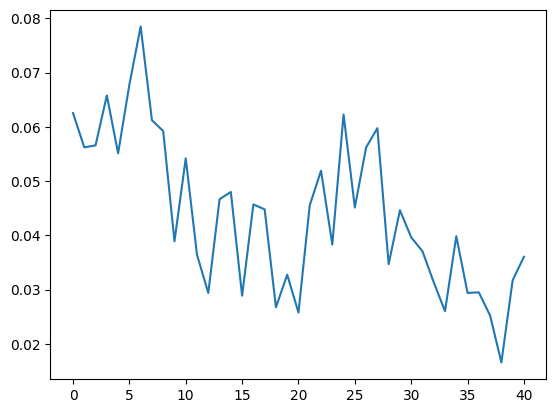

In [ ]:
plt.plot(history.history['loss'])

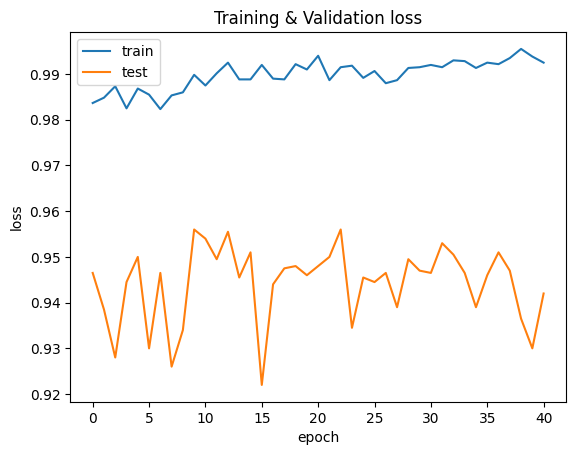

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(W_test)
preds = np.zeros((predictions.shape[0],))
for i in range(len(predictions)):
    preds[i] = np.argmax(predictions[i])
preds

63/63 [==============================] - 1s 13ms/step


array([1., 1., 1., ..., 0., 0., 1.])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score1 = accuracy_score(Y_test,preds)
accuracy_score1

0.949

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       986
           1       0.94      0.97      0.95      1014

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
def classifier2(in_shape=(400,3,1), n_classes=2):
  # image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(64, (3,3), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(128, (3,3), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	#out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	output = Dense(n_classes, activation='softmax')(fe)
	model = Model(in_image, output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['sparse_categorical_crossentropy'],
                  optimizer=opt,
                 metrics='accuracy')
	
	return model

In [ ]:
model2 = classifier2()
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 400, 3, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 400, 3, 64)        640       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 400, 3, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 400, 3, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 400, 3, 128)       73856     
                                                                 
 batch_normalization_22 (Bat  (None, 400, 3, 128)      512       
 chNormalization)                                                
                                                           

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
history = model2.fit(X_train,y_train, epochs=10, batch_size = 64,
                   validation_data = (X_val, y_val), 
                    #callbacks=[callback]
                    )

Epoch 1/10
94/94 [==============================] - 5s 48ms/step - loss: 0.4923 - accuracy: 0.8497 - val_loss: 0.8739 - val_accuracy: 0.5010
Epoch 2/10
94/94 [==============================] - 4s 45ms/step - loss: 0.3392 - accuracy: 0.9060 - val_loss: 1.1107 - val_accuracy: 0.5010
Epoch 3/10
94/94 [==============================] - 5s 48ms/step - loss: 0.2756 - accuracy: 0.9200 - val_loss: 0.6704 - val_accuracy: 0.6070
Epoch 4/10
94/94 [==============================] - 4s 46ms/step - loss: 0.2779 - accuracy: 0.9202 - val_loss: 0.4810 - val_accuracy: 0.7760
Epoch 5/10
94/94 [==============================] - 4s 45ms/step - loss: 0.2680 - accuracy: 0.9283 - val_loss: 0.2513 - val_accuracy: 0.9050
Epoch 6/10
94/94 [==============================] - 5s 48ms/step - loss: 0.2721 - accuracy: 0.9295 - val_loss: 0.2132 - val_accuracy: 0.9345
Epoch 7/10
94/94 [==============================] - 4s 46ms/step - loss: 0.2170 - accuracy: 0.9428 - val_loss: 0.2977 - val_accuracy: 0.9145
Epoch 8/10
94

In [ ]:
predictions = model2.predict(W_test)
preds2 = np.zeros((predictions.shape[0],))
for i in range(len(predictions)):
    preds2[i] = np.argmax(predictions[i])
preds2

63/63 [==============================] - 0s 6ms/step


array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
accuracy_score2 = accuracy_score(Y_test,preds2)
accuracy_score2

0.927

In [ ]:
print(classification_report(Y_test, preds2))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       986
           1       0.90      0.96      0.93      1014

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



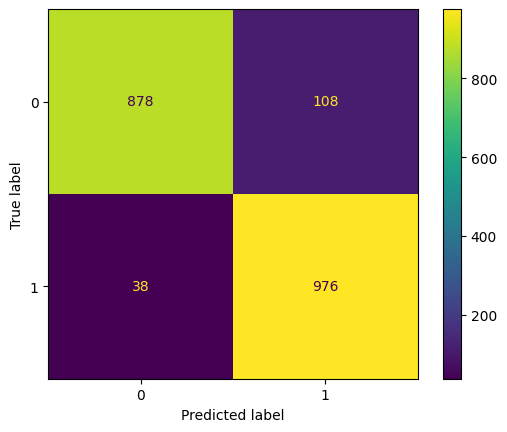

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, preds2, )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()
plt.show()

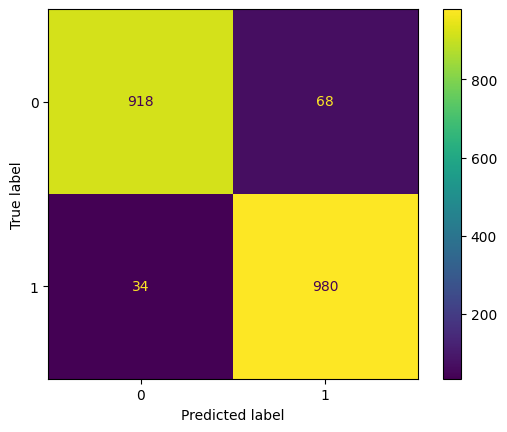

In [ ]:
cm = confusion_matrix(Y_test, preds, )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()
plt.show()